In [127]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import shapefile
import pandas as pd
import datetime
from shapely.geometry import Point, Polygon, MultiPolygon # for working with data polygons
import time
import csv

In [128]:
# Read in shapefile
sf = shapefile.Reader("./joaquin_data/201907/United States_fires_jul_2019")

In [129]:
# Create list of field names
fields = [ field[0] for field in sf.fields[1:] ]

# Create list roecord lists
records = [ record[:] for record in sf.records() ]

# Create list of polygons from shapes
polygons = [ Polygon(shape.points) for shape in sf.shapes() ]

# Create dataframe from shapefile
df = pd.DataFrame(columns=fields, data=records)
df = df.assign(Polygon=polygons)

In [130]:
# Sort unique fires into separate dataframes
fire_df_list = []
for uid in np.unique(df['Id']):
    mask = [ (id == uid) for id in df['Id'] ]
    fire_df_list.append(df[mask])

FOR each fire

In [131]:
then = time.time()
# Initialize array for all fire data
# fire_data = np.empty(shape=(1000000, 4))
# fire_data_index = 0
fire_data = []

for fire_df in fire_df_list[0:1]:
# fire_df = fire_df_list[0] # for debugging

    # Get number of fire days
    init_date = fire_df.iloc[-1]['IDate'] # gets initial date of final area
    final_date = fire_df.iloc[-1]['FDate'] # gets final data of final area
    fire_days = (final_date - init_date).days + 1 # day 0 = initial date, day [last] = final date

    # Create empty multipolygon array. Last row to contain final area
    multipolygon_array = np.zeros(shape=(fire_days+1,), dtype=MultiPolygon)

    # FOR each day of the fire
    for day in range(fire_days):
        # Define date starting from initial fire date
        date = init_date + datetime.timedelta(day)
        # Create empty polygon list for storing polygons active each day
        active_polygons = []

        # FOR all but last row of the fire 
        for i, row in fire_df.head(-1).iterrows():       
            # IF row is active during that day
            if (row['IDate']<=date) and (date<=row['FDate']):          
                # Append to polygon list
                active_polygons.append(row['Polygon'])

        # Create multipolygon using active polygons list
        multipolygon = MultiPolygon(active_polygons)

        # Append day and MutliPolygon to multipolygon list
        multipolygon_array[day] = multipolygon

    # Add final area polygon to end for bounding box information
    multipolygon = MultiPolygon([fire_df.iloc[-1]['Polygon']])
    multipolygon_array[fire_days] = multipolygon
    
    #-----------------------------------------------------------------------------#
    # Get centriod x,y coors of first day multipolygon
    origin = multipolygon_array[0].centroid
    x_o,y_o = origin.xy

    # Normalize the multipolygons
    # Create empty multipolygon array. Last row to contain final area
    norm_multipolygon_array = np.zeros(shape=np.shape(multipolygon_array), dtype=MultiPolygon)

    for day, multipolygon in enumerate(multipolygon_array):
        # Create empty list for storing new normalized polygons
        norm_polygon_list = []
        for polygon in multipolygon:

            # Get x,y coords for the polygon
            x,y = polygon.exterior.xy
            # Normalize the coords by origin coords
            norm_x = np.subtract(x,x_o)
            norm_y = np.subtract(y,y_o)
            # Build new polygon and append to list
            norm_coords = np.array((norm_x, norm_y)).T
            norm_polygon = Polygon(norm_coords)
            norm_polygon_list.append(norm_polygon)

        # Create new normalized multipolygon from normed polygon list
        norm_multipolygon = MultiPolygon(norm_polygon_list)
        # Insert into array
        norm_multipolygon_array[day] = norm_multipolygon

    # Create new "normalized" dataframe with multipolygons and origin
    norm_fire_df = pd.DataFrame()
    norm_fire_df = norm_fire_df.assign(MultiPolygon = norm_multipolygon_array)
    norm_fire_df = norm_fire_df.assign(Origin = origin)

    # Normalized fire dataframe will be appended to list of normalized dataframes
    
    #-----------------------------------------------------------------------------#
    # Get bounding box of final area
    bounding_box = norm_fire_df.iloc[-1]['MultiPolygon'].bounds

    # Determine minimum "pixel" size from smallest difference in coords
    dx = 0.004166666666293395 # for now I'll hard-code this

    # Produce array of discreted longitude and latitude "pixel" points
    longs = np.arange( (bounding_box[0]+dx/2), (bounding_box[2]-dx/2), dx )
    lats = np.arange( (bounding_box[1]+dx/2), (bounding_box[3]-dx/2), dx )

    coords = []
    for long in longs:
        for lat in lats:
            coords.append([long, lat])

    N = len(coords)
    D = fire_days
    data = np.zeros((N*D, 4))
    # FOR each day of the fire
    for d in range(D):
        # FOR each coord in a day
        for i, c in enumerate(coords):
            # Set data point day and coords
            data[d*N+i][0] = d
            data[d*N+i][1:3] = c
            # IF coord is contained by MultiPolygon for that day
            if norm_fire_df.iloc[d]['MultiPolygon'].contains(Point(c)):
                # Set y at index to 1
                data[d*N+i][3] = 1
                
            # add datapoint to master fire_data array
            fire_data.append(data[d*N+i])
#             fire_data[fire_data_index] = data[d*N+i]
#             fire_data_index += 1

# Timing
now = time.time()
delta = now-then
print(delta)

2.0251822471618652


In [124]:
fire_data_fields = ['day', 'long', 'lat', 'burning']
with open('fire_data_all.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(fire_data_fields)
    write.writerows(fire_data)

In [125]:
fire_data_np = np.array(fire_data)
np.savetxt('fire_data_all.csv',fire_data_np, delimiter = ',')

Time to learn!

Plotting

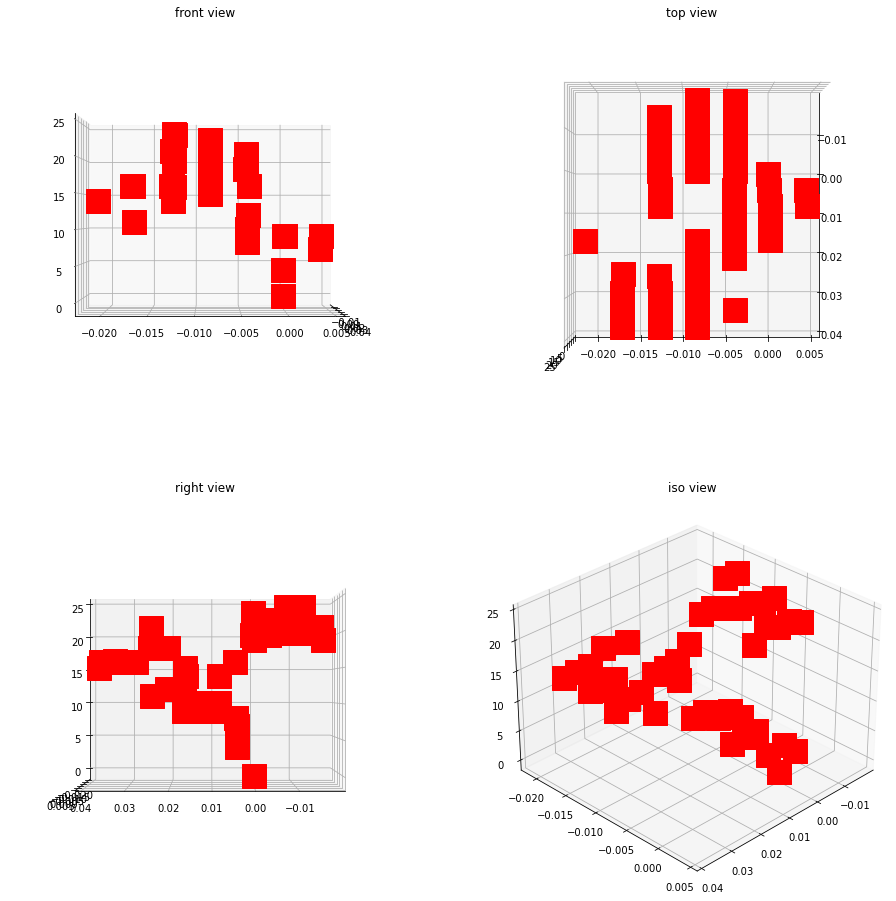

In [132]:
fig = plt.figure(3, figsize=(16,16))
ax = fig.add_subplot(221, projection='3d')
for point in data:
    if point[3]:
        x = point[1]
        y = point[2]
        z = point[0]
        c = z/24+0.1
        ax.scatter(x, y, z, color='r', marker='s', s = 600)
ax.view_init(elev=0, azim=0)
ax.set_title('front view')

ax = fig.add_subplot(222, projection='3d')
for point in data:
    if point[3]:
        x = point[1]
        y = point[2]
        z = point[0]
        ax.scatter(x, y, z, color='r', marker='s', s = 600)
ax.view_init(elev=90, azim=0)
ax.set_title('top view')

ax = fig.add_subplot(223, projection='3d')
for point in data:
    if point[3]:
        x = point[1]
        y = point[2]
        z = point[0]
        ax.scatter(x, y, z, color='r', marker='s', s = 600)
ax.view_init(elev=0, azim=90)
ax.set_title('right view')

ax = fig.add_subplot(224, projection='3d')
for point in data:
    if point[3]:
        x = point[1]
        y = point[2]
        z = point[0]
        ax.scatter(x, y, z, color='r', marker='s', s = 600)
ax.view_init(elev=30, azim=45)
ax.set_title('iso view')

plt.show()

Text(0.5, 0.92, 'a view')

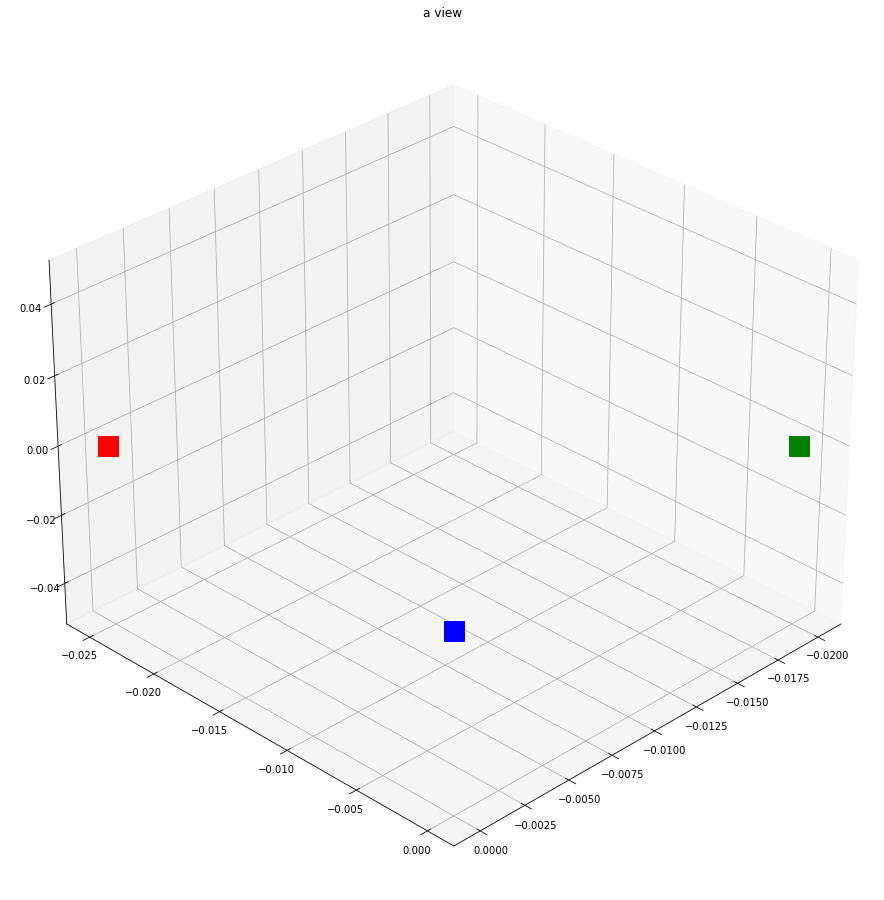

In [95]:
fig = plt.figure(3, figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
for point in data:
    if point[3]:
        x = point[1]
        y = point[2]
        z = point[0]
        c = z/24+0.1
#         ax.scatter(x, y, z, c='k')
        
        ax.plot(x, z, 'rs', ms=20, zdir='y', zs=-0.025)
        ax.plot(y, z, 'gs', ms=20, zdir='x', zs=-0.02)
        ax.plot(x, y, 'bs', ms=20, zdir='z')
        
ax.view_init(elev=30, azim=45)
ax.set_title('a view')

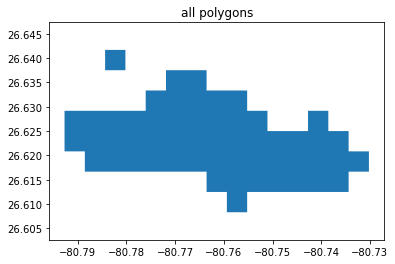

In [55]:
# Plot polygons
fig = plt.figure(2,)
ax = fig.add_subplot(111)
ax.set_title('all polygons')

for shape in shapes[26:27]:
    polygon = Polygon(shape.points)
    x, y = polygon.exterior.xy
    ax.fill(x, y)
    ax.axis('equal')

plt.show()